# Classification of Review Sentiments Using Machine Learning

In [3]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import *
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import re
import nltk, wordcloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

## Loading NLP Libraries
For appling language processing techniques such as text cleaning, tokenization, stopwords removal, lemmatization, etc, we need to load libraries such as `nltk`, `wordnet`, `stopwords`, etc. The following code will download the necessary libraries.

In [4]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\azazb\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\azazb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\azazb\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\azazb\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## Loading Dataset
The dataset is loaded from a CSV file named `output.csv`. The dataset contains two columns: `content` and `is_positive`. The `content` column contains the text data, and the `is_positive` column contains the labels.

In [5]:
data = pd.read_csv("output.csv", encoding="ISO-8859-1")
data.head(7)

,id,app_id,content,author_id,is_positive
0,181331361,100.0,At least its a counter strike -1/100,7.656120e+16,Negative
1,180872601,100.0,Uh... So far my playthrough has not been great...,7.656120e+16,Negative
2,177836246,100.0,Better mechanics than cs2,7.656120e+16,Negative
3,177287444,100.0,buggy mess and NOT fun to play at all,7.656120e+16,Negative
4,176678990,100.0,"Whoever came up with this, is gonna fucking ge...",7.656120e+16,Negative
5,176118004,100.0,Every enemy and their grandmother have aimbot ...,7.656120e+16,Negative
6,172896379,100.0,l,7.656120e+16,Negative


## Data Information (Analysis, EDA)
Data analysis is a crucial step in any data science project. It helps us understand the dataset, identify patterns, and make informed decisions. The following code will provide us with the basic information about the dataset, such as the number of rows and columns, the data types of the columns, and the number of missing values in each column.


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201202 entries, 0 to 201201
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   id           201202 non-null  object 
 1   app_id       201153 non-null  float64
 2   content      200725 non-null  object 
 3   author_id    201149 non-null  float64
 4   is_positive  201149 non-null  object 
dtypes: float64(2), object(3)
memory usage: 7.7+ MB


In [7]:
data.shape

(201202, 5)

### Taking Dataset Portion
The original dataset is very large, so we will take a portion of the dataset, keeping in view memory limitatiosn and our computational power. The following code will take **10,000** samples from each class while maintaining the same class distribution.

This procedure is applied in following manner:

1. Calculating the current class distribution.
2. Selection of 10,000 samples while maintaining the same class distribution.
3. Resetting the index of the sampled dataset.
4. Verifying the new shape.
5. Verifying the class distribution.


In [8]:
# calculate the current class distribution
original_distribution = data['is_positive'].value_counts(normalize=True)

# select N samples while maintaining the same class distribution
sampled_data = data.groupby('is_positive', group_keys=False).apply(
    lambda x: x.sample(n=int(40000 * original_distribution[x.name]), random_state=42)
)

# reset the index of the sampled dataset
sampled_data = sampled_data.reset_index(drop=True)

# verify the new shape
print("Original shape:", data.shape)
print("Sampled shape:", sampled_data.shape)

# verify the class distribution is maintained
print("\nOriginal class distribution:")
print(data['is_positive'].value_counts(normalize=True))
print("\nSampled class distribution:")
print(sampled_data['is_positive'].value_counts(normalize=True))

Original shape: (201202, 5)
Sampled shape: (39999, 5)

Original class distribution:
is_positive
Positive    0.510368
Negative    0.489632
Name: proportion, dtype: float64

Sampled class distribution:
is_positive
Positive    0.510363
Negative    0.489637
Name: proportion, dtype: float64


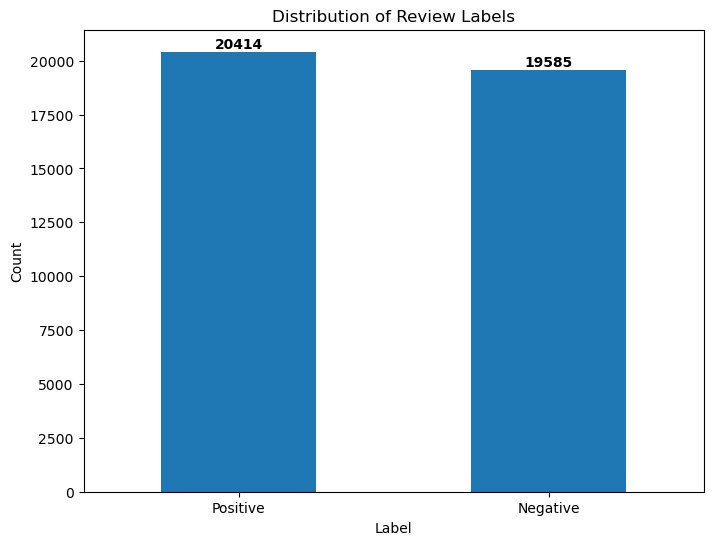

In [9]:
# create the bar plot
fig, ax = plt.subplots(figsize=(8, 6))
bars = sampled_data['is_positive'].value_counts().plot(kind='bar')
plt.title('Distribution of Review Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)

# add value annotations on top of each bar
for i, v in enumerate(sampled_data['is_positive'].value_counts()):
    ax.text(i, v, str(v), 
            ha='center', va='bottom',
            fontweight='bold')

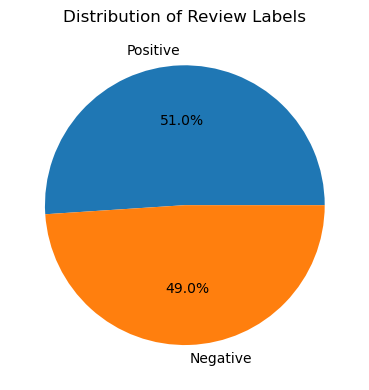

In [10]:
# pie Chart
plt.figure(figsize=(7, 4))
sampled_data['is_positive'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Review Labels')
plt.ylabel('')
plt.tight_layout()
plt.show()

## Text Preprocessing
Text preprocessing is a crucial step in any text classification task. It involves cleaning the text data to remove noise and irrelevant information, and transforming it into a format that can be easily processed by machine learning algorithms. The following code will perform the following preprocessing steps:

1. Converting the text to lowercase.
2. Removing URLs.
3. Removing HTML tags.
4. Removing special characters and numbers.
5. Removing extra whitespace.
6. Tokenizing the text.
7. Removing stopwords.
8. Lemmatizing the text.


In [11]:
def preprocess_text(text):
    # convert to lowercase
    text = str(text).lower()
    
    # remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # tokenization
    tokens = word_tokenize(text)
    
    # remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # join tokens back into text
    return ' '.join(tokens)

# applying preprocessing to the 'content' column
sampled_data['cleaned_content'] = sampled_data['content'].apply(preprocess_text)

### Applying Function ``preprocess_text`` to the ``content`` column

In [12]:
# displaying a few examples of original and cleaned text
print("Original vs Cleaned Text Examples:")
for i in range(3):
    print("\nOriginal:", sampled_data['content'].iloc[i])
    print("Cleaned:", sampled_data['cleaned_content'].iloc[i])

Original vs Cleaned Text Examples:

Original: A reminder of how crappy games were 10 years ago
Cleaned: reminder crappy game year ago

Original: I really like this game its cool
Cleaned: really like game cool

Original: blue shift? more like bull shit

hl1 is great, hl:of is great, hl:bs is meh

it's not bad but it also ain't that good
you could probably skip this one and not miss out on anything special
Cleaned: blue shift like bull shit hl great hlof great hlbs meh bad also aint good could probably skip one miss anything special


In [13]:
sampled_data.head(7)

,id,app_id,content,author_id,is_positive,cleaned_content
0,9925216,220.0,A reminder of how crappy games were 10 years ago,7.656120e+16,Negative,reminder crappy game year ago
1,120402387,220.0,I really like this game its cool,7.656120e+16,Negative,really like game cool
2,14801220,130.0,blue shift? more like bull shit\n\nhl1 is grea...,7.656120e+16,Negative,blue shift like bull shit hl great hlof great ...
3,179268339,570.0,garbage,7.656120e+16,Negative,garbage
4,152310822,570.0,trash game !!!,7.656120e+16,Negative,trash game
5,9402482,280.0,I like Half Life. It is one of my all time fav...,7.656120e+16,Negative,like half life one time favourite fps game bel...
6,129581512,570.0,sdgsg,7.656120e+16,Negative,sdgsg


### Further Analysis

### Word Count Analysis ###


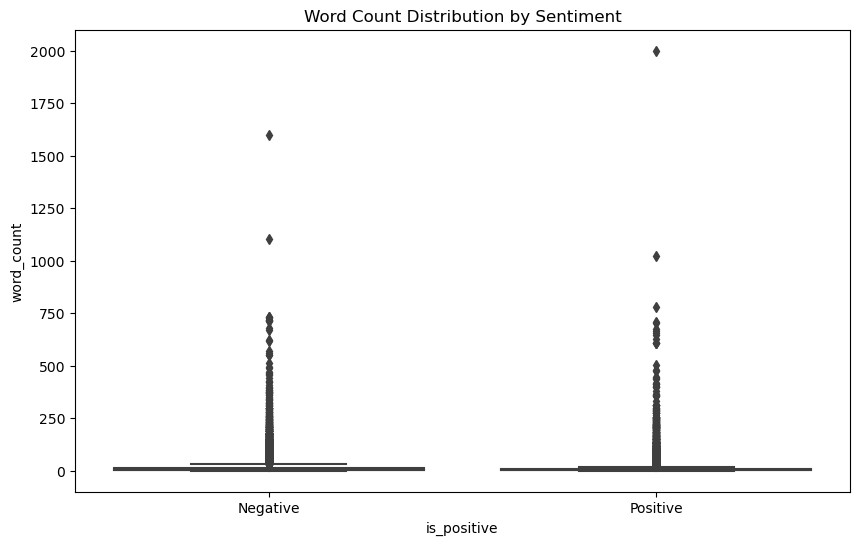

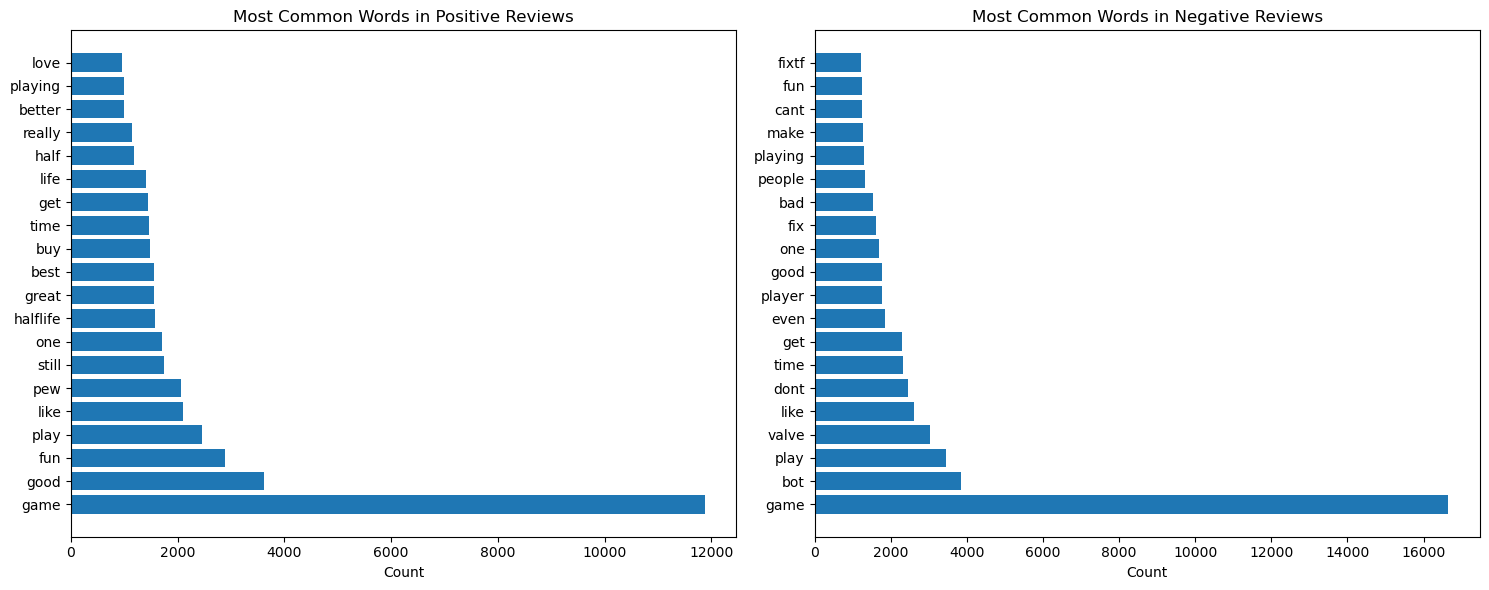


### Text Length Statistics ###

Positive Reviews:
count    20414.000000
mean        11.292691
std         33.766579
min          0.000000
25%          2.000000
50%          4.000000
75%          9.000000
max       2000.000000
Name: word_count, dtype: float64

Negative Reviews:
count    19585.000000
mean        15.938933
std         39.617942
min          0.000000
25%          2.000000
50%          5.000000
75%         14.000000
max       1599.000000
Name: word_count, dtype: float64


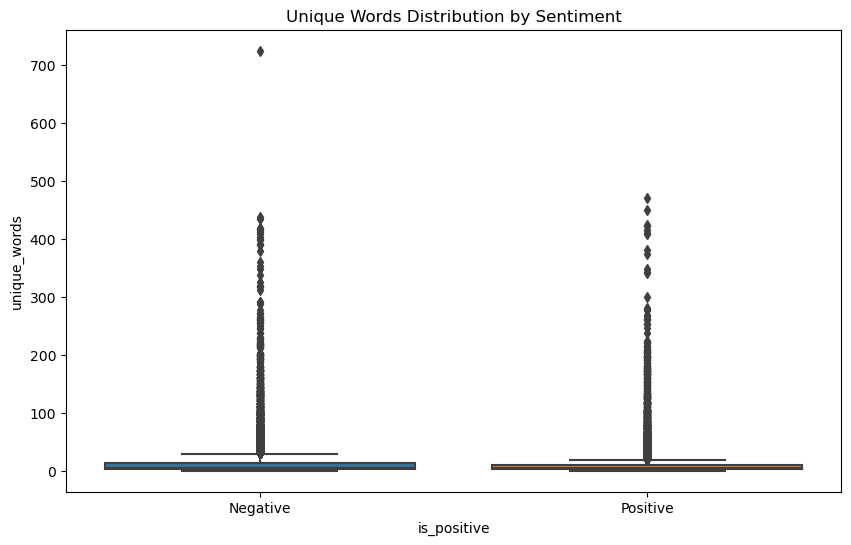

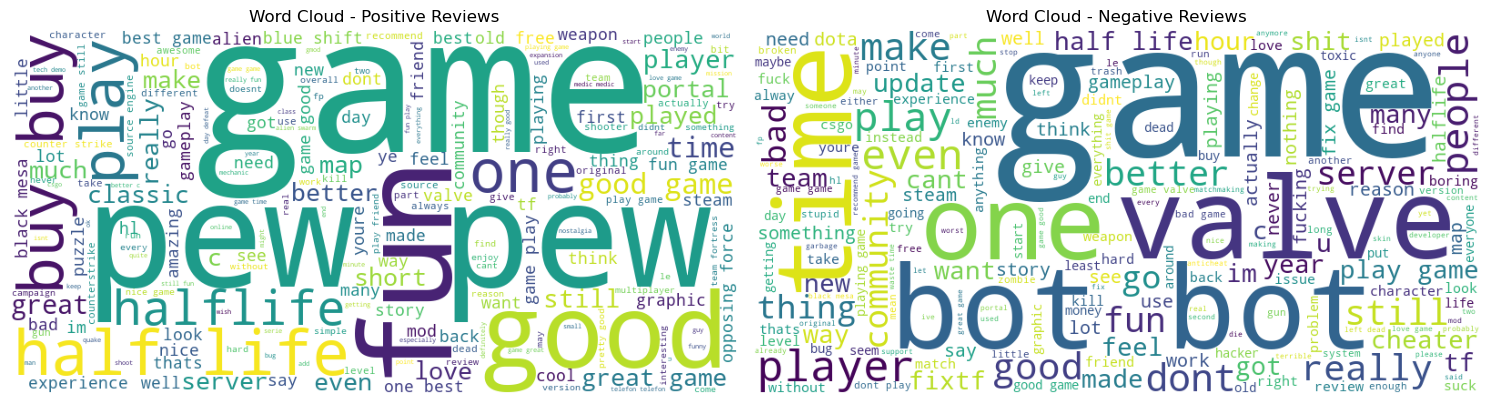

In [14]:
# 1. Word Count Analysis
print("### Word Count Analysis ###")
sampled_data['word_count'] = sampled_data['cleaned_content'].str.split().str.len()

plt.figure(figsize=(10, 6))
sns.boxplot(x='is_positive', y='word_count', data=sampled_data)
plt.title('Word Count Distribution by Sentiment')
plt.show()

# 2. Most Common Words Analysis
from collections import Counter
import itertools

def get_most_common_words(texts, n=20):
    words = list(itertools.chain(*[text.split() for text in texts]))
    return Counter(words).most_common(n)

# Separating positive and negative reviews
positive_reviews = sampled_data[sampled_data['is_positive'] == 'Positive']['cleaned_content']
negative_reviews = sampled_data[sampled_data['is_positive'] == 'Negative']['cleaned_content']

# Getting most common words for each sentiment
pos_common_words = get_most_common_words(positive_reviews)
neg_common_words = get_most_common_words(negative_reviews)

# Plotting most common words
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Positive reviews
words, counts = zip(*pos_common_words)
ax1.barh(words, counts)
ax1.set_title('Most Common Words in Positive Reviews')
ax1.set_xlabel('Count')

# Negative reviews
words, counts = zip(*neg_common_words)
ax2.barh(words, counts)
ax2.set_title('Most Common Words in Negative Reviews')
ax2.set_xlabel('Count')

plt.tight_layout()
plt.show()

# 3. Text Length Statistics
print("\n### Text Length Statistics ###")
print("\nPositive Reviews:")
print(sampled_data[sampled_data['is_positive'] == 'Positive']['word_count'].describe())
print("\nNegative Reviews:")
print(sampled_data[sampled_data['is_positive'] == 'Negative']['word_count'].describe())

# 4. Unique Words Analysis
def count_unique_words(text):
    return len(set(text.split()))

sampled_data['unique_words'] = sampled_data['cleaned_content'].apply(count_unique_words)

plt.figure(figsize=(10, 6))
sns.boxplot(x='is_positive', y='unique_words', data=sampled_data)
plt.title('Unique Words Distribution by Sentiment')
plt.show()

# 5. Word Cloud Visualization
from wordcloud import WordCloud

plt.figure(figsize=(15, 6))

# Positive reviews word cloud
plt.subplot(1, 2, 1)
positive_text = ' '.join(positive_reviews)
wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
plt.imshow(wordcloud_pos)
plt.title('Word Cloud - Positive Reviews')
plt.axis('off')

# Negative reviews word cloud
plt.subplot(1, 2, 2)
negative_text = ' '.join(negative_reviews)
wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(negative_text)
plt.imshow(wordcloud_neg)
plt.title('Word Cloud - Negative Reviews')
plt.axis('off')

plt.tight_layout()
plt.show()

## Word Vectorization
Word vectorization is a technique used to represent words as numerical vectors, which can be easily processed by machine learning algorithms. The following code will use the `TfidfVectorizer` to convert the text data into a matrix of TF-IDF features.


In [15]:
# initializing the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# fitting the vectorizer on the cleaned content
X_tfidf = tfidf_vectorizer.fit_transform(sampled_data['cleaned_content'])

In [16]:
# displaying the shape of the TF-IDF matrix
X_tfidf.shape


(39999, 5000)

In [17]:
# selection of target variable
y = (sampled_data['is_positive'] == 'Positive').astype(int)

y.shape

(39999,)

## Spliting Dataset into Training and Testing Sets
We will use 80% of the data for training and 20% for testing, using a function from `sklearn.model_selection` called `train_test_split`. This function will split the dataset into training and testing sets, and return the training and testing sets as well as the target variables for both sets.

In [18]:
X_tfidf_train, X_tfidf_test, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, 
                                                                            y, 
                                                                            test_size=0.2, 
                                                                            random_state=42, 
                                                                            stratify=y)

# displaying the shape of the training and testing sets
X_tfidf_train.shape, X_tfidf_test.shape, y_train_tfidf.shape, y_test_tfidf.shape

((31999, 5000), (8000, 5000), (31999,), (8000,))

## Applying Models
We will apply the following models:

1. Random Forest
2. Support Vector Machine
3. Naive Bayes

We will use the `evaluate_model` function to evaluate the performance of each model. This function will take the model, the training and testing sets, and the target variables as input, and will return the accuracy, the classification report, and the confusion matrix.


### ``evaluate_model`` Function 

In [19]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name, vectorizer_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f"\n{model_name} with {vectorizer_name}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name} ({vectorizer_name})')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

### Applying Random Forest Model


Random Forest with TF-IDF
Accuracy: 80.00%

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.75      0.79      3917
           1       0.78      0.85      0.81      4083

    accuracy                           0.80      8000
   macro avg       0.80      0.80      0.80      8000
weighted avg       0.80      0.80      0.80      8000



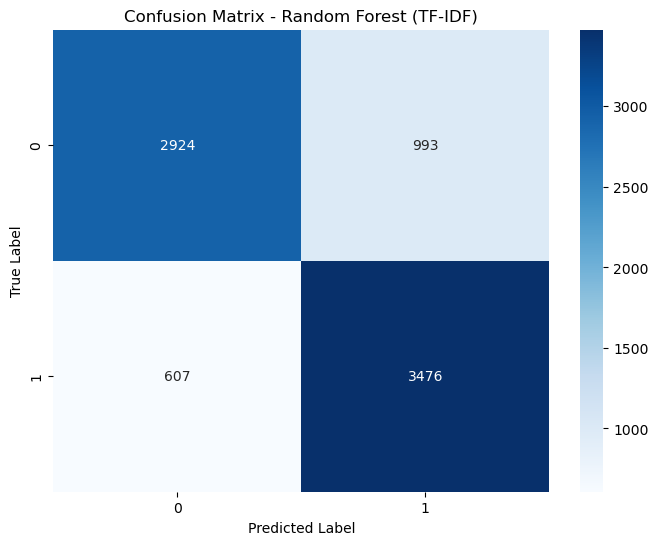

CPU times: total: 3min 13s
Wall time: 3min 23s


In [20]:
%%time
rf = RandomForestClassifier(n_estimators=100, 
                            random_state=42)
# applying the model   
evaluate_model(rf, X_tfidf_train, X_tfidf_test, 
               y_train_tfidf, y_test_tfidf, 
               "Random Forest", "TF-IDF")

### Applying Support Vector Machine Model



Support Vector Machine with TF-IDF
Accuracy: 80.40%

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.75      0.79      3917
           1       0.78      0.86      0.82      4083

    accuracy                           0.80      8000
   macro avg       0.81      0.80      0.80      8000
weighted avg       0.81      0.80      0.80      8000



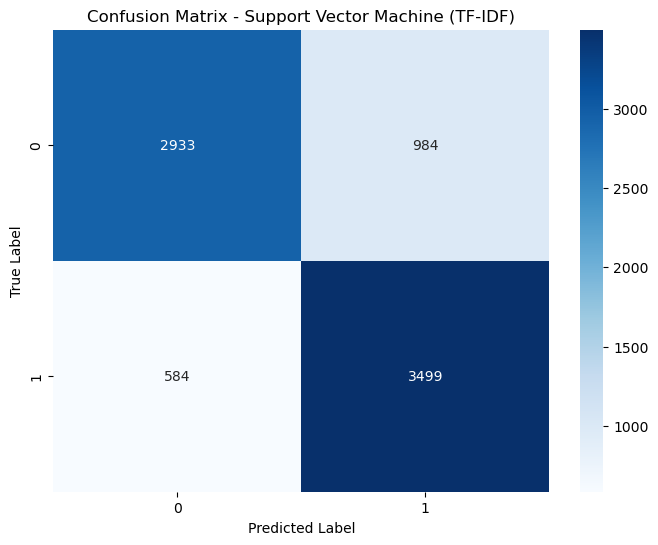

CPU times: total: 1min 29s
Wall time: 1min 32s


In [21]:
%%time
svm = SVC(kernel='linear', random_state=42)

# applying the model   
evaluate_model(svm, X_tfidf_train, X_tfidf_test, 
               y_train_tfidf, y_test_tfidf, 
               "Support Vector Machine", "TF-IDF")    

### Applying Naive Bayes Model


Naive Bayes with TF-IDF
Accuracy: 80.94%

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.75      0.79      3917
           1       0.78      0.87      0.82      4083

    accuracy                           0.81      8000
   macro avg       0.81      0.81      0.81      8000
weighted avg       0.81      0.81      0.81      8000



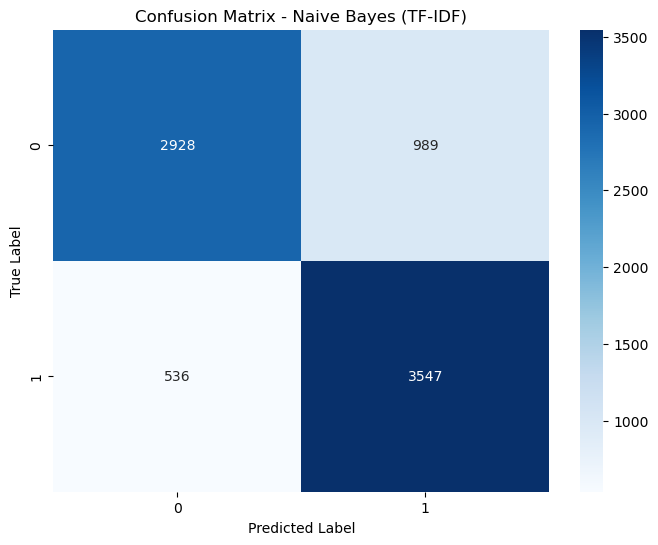

CPU times: total: 297 ms
Wall time: 298 ms


In [22]:
%%time
nb = MultinomialNB()

# applying the model   
evaluate_model(nb, X_tfidf_train, X_tfidf_test, 
               y_train_tfidf, y_test_tfidf, 
               "Naive Bayes", "TF-IDF")

## Comparing Models
We will compare the performance of the three models using the `print_sample_predictions` function. This function will take the model, the testing set, and the target variable as input, and will print the original text, the predicted label, and the actual label for a random sample of 5 reviews.

<BarContainer object of 3 artists>

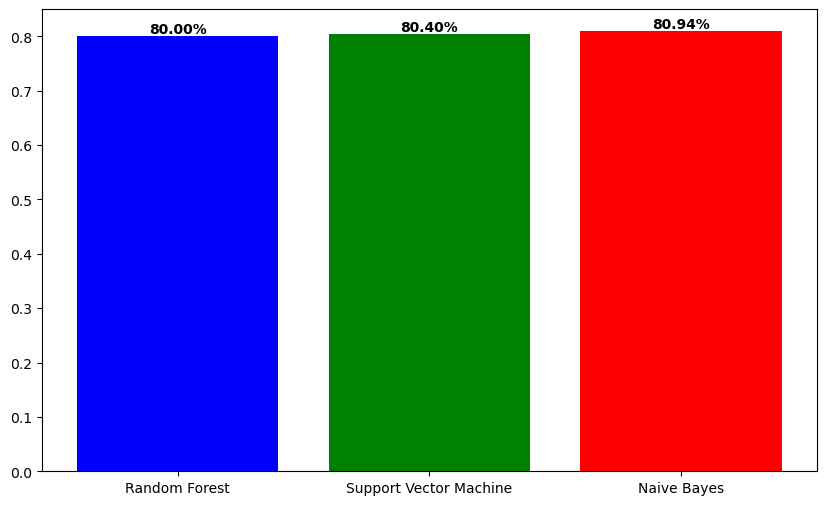

In [23]:
# bar chart for model comparison
fig, ax = plt.subplots(figsize=(10, 6))

# adding annotations to the bars
for i, v in enumerate([accuracy_score(y_test_tfidf, rf.predict(X_tfidf_test)), 
                      accuracy_score(y_test_tfidf, svm.predict(X_tfidf_test)), 
                      accuracy_score(y_test_tfidf, nb.predict(X_tfidf_test))]):
    ax.text(i, v, f"{v*100:.2f}%", 
            ha='center', va='bottom', 
            fontweight='bold')

# plotting the accuracy scores
ax.bar(['Random Forest', 'Support Vector Machine', 'Naive Bayes'], 
       [accuracy_score(y_test_tfidf, rf.predict(X_tfidf_test)), 
        accuracy_score(y_test_tfidf, svm.predict(X_tfidf_test)), 
        accuracy_score(y_test_tfidf, nb.predict(X_tfidf_test))], 
       color=['blue', 'green', 'red'])


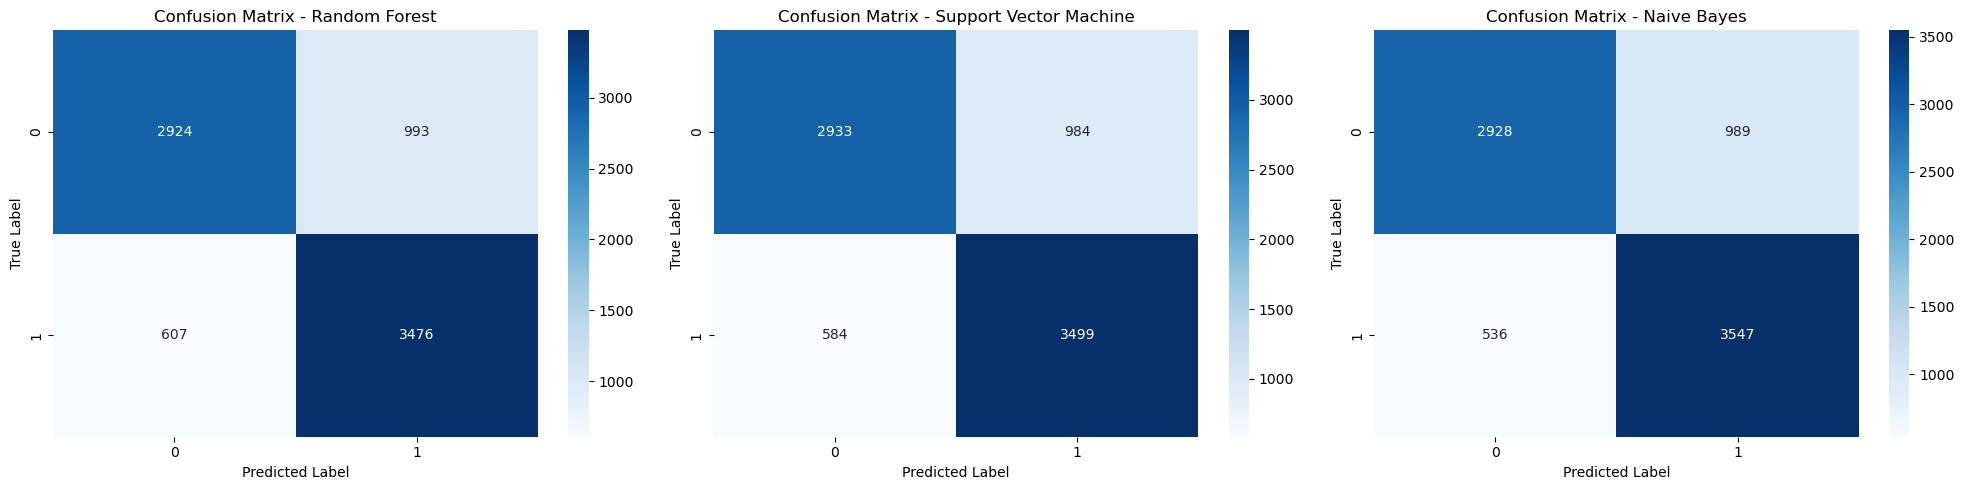

In [24]:
# Create a function to plot confusion matrices side by side
def plot_confusion_matrices(models, X_test, y_test, model_names):
   # create subplots in a single row
   fig, axes = plt.subplots(1, len(models), figsize=(20, 5))
   
   for i, (model, name) in enumerate(zip(models, model_names)):
       # get predictions
       y_pred = model.predict(X_test)
       
       # calculate confusion matrix
       cm = confusion_matrix(y_test, y_pred)
       
       # plot confusion matrix
       sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
       axes[i].set_title(f'Confusion Matrix - {name}')
       axes[i].set_ylabel('True Label')
       axes[i].set_xlabel('Predicted Label')
   
   plt.tight_layout()
   plt.show()

# Create list of models and their names
models = [rf, svm, nb]
model_names = ['Random Forest', 'Support Vector Machine', 'Naive Bayes']

# Plot all confusion matrices
plot_confusion_matrices(models, X_tfidf_test, y_test_tfidf, model_names)

In [25]:
def print_sample_predictions(model, X_test, y_test, original_texts, n_samples):
    # get predictions
    y_pred = model.predict(X_test)
    
    # get original texts (assuming they're in the same order as X_test)
    sample_indices = np.random.choice(len(y_test), n_samples, replace=False)
    
    print("\nSample Predictions vs Actual Labels:")
    print("-" * 80)
    
    for idx in sample_indices:
        print(f"Text: {original_texts[idx]}")
        print(f"Predicted: {'Positive' if y_pred[idx] == 1 else 'Negative'}")
        print(f"Actual: {'Positive' if y_test.iloc[idx] == 1 else 'Negative'}")
        print("-" * 80)

In [26]:
print_sample_predictions(rf, X_tfidf_test, y_test_tfidf, sampled_data['content'], n_samples=5)


Sample Predictions vs Actual Labels:
--------------------------------------------------------------------------------
Text: cancer
Predicted: Negative
Actual: Negative
--------------------------------------------------------------------------------
Text: "TF2 community, we hear you! We love this game and know you do, too. We see how large this issue has become and are working to improve things."

They've done nothing about this.
Predicted: Positive
Actual: Positive
--------------------------------------------------------------------------------
Text: why shoot zombies, just parkour around them, no need to fight. no reason to anyway, this is walking simulator
Predicted: Negative
Actual: Positive
--------------------------------------------------------------------------------
Text: made this steam account years ago just to play this piece of shit lol
Predicted: Negative
Actual: Negative
--------------------------------------------------------------------------------
Text: FULL OF CHEATS

## Visualizing Feature Importance
We will use the `visualize_feature_importance` function to visualize the most important features from the Random Forest model. This function will take the model, the vectorizer, and the number of features to display as input, and will return the top features and their importance scores.

    """
    Visualize the most important features from a Random Forest model.
    
    Parameters:
    -----------
    rf_model : RandomForestClassifier
        Trained Random Forest model
    vectorizer : TfidfVectorizer
        Fitted TF-IDF vectorizer
    n_features : int
        Number of top features to display (default=20)
    """


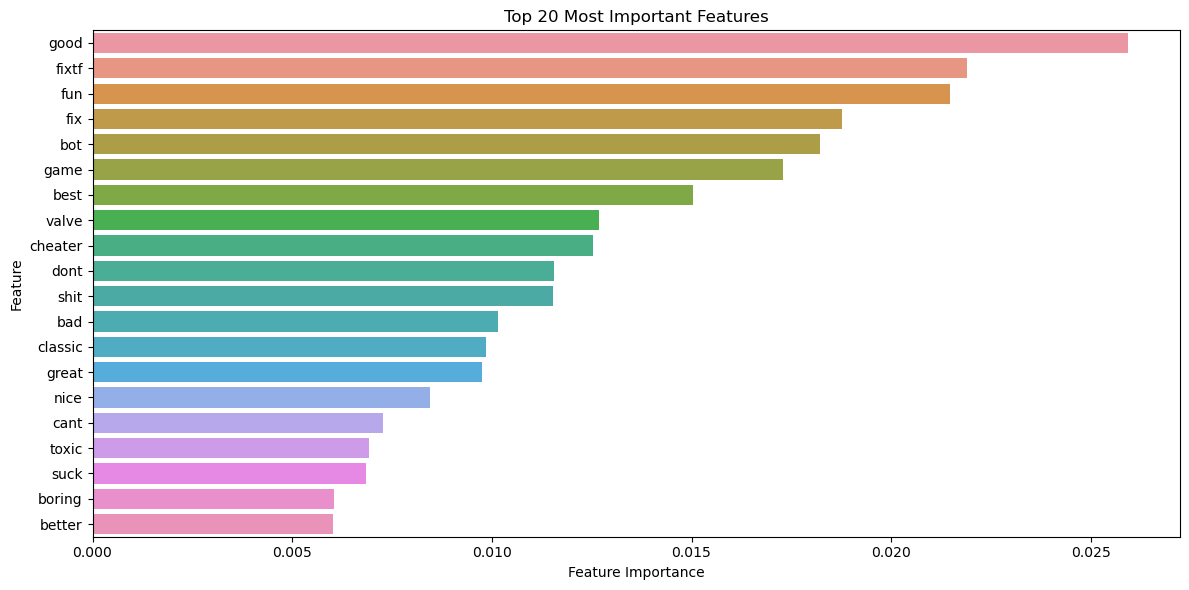


Top feature importance scores:
good: 0.0259
fixtf: 0.0219
fun: 0.0215
fix: 0.0188
bot: 0.0182
game: 0.0173
best: 0.0150
valve: 0.0127
cheater: 0.0125
dont: 0.0115
shit: 0.0115
bad: 0.0102
classic: 0.0098
great: 0.0097
nice: 0.0085
cant: 0.0073
toxic: 0.0069
suck: 0.0068
boring: 0.0060
better: 0.0060


In [27]:
def visualize_feature_importance(rf_model, vectorizer, n_features=20):
    
    # get feature names and importance scores
    feature_names = vectorizer.get_feature_names_out()
    importances = rf_model.feature_importances_
    
    # create a dataframe of features and their importance scores
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    })
    
    # sort by importance and get top n_features
    top_features = feature_importance.sort_values('importance', ascending=False).head(n_features)
    
    # create the visualization
    plt.figure(figsize=(12, 6))
    sns.barplot(data=top_features, x='importance', y='feature')
    plt.title(f'Top {n_features} Most Important Features')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
    
    # print the numerical values
    print("\nTop feature importance scores:")
    for idx, row in top_features.iterrows():
        print(f"{row['feature']}: {row['importance']:.4f}")

# call the function
visualize_feature_importance(rf, tfidf_vectorizer)

## Next Steps
Till now, we have used a subset of data and applied 3 machine learning models for classification, achieving a decent result of about 80% on test samples. We can enhance the performance of these models by:
* Using more samples
* Fine-Tuning Models to Obtain Optimal Hyperparameters
* Using deep learning models like RNNs, LSTMs and Trrnsformers

In the next notebook, we'll try to upscale the performnce of these models using more advanced architectures!